In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np



In [30]:
df = pd.read_csv("data.csv")
df.head(2)

,STATION ID,STATION NAME,DATE,DAILY AVG TEMP (DEG F),DAILY MAX TEMP (DEG F),DAILY MIN TEMP (DEG F),DAILY PRECIPITATION TOTAL (INCHES)
0,USW00093821,"LOUISVILLE INTERNATIONAL AIRPORT, KY US",1/1/48,44.5,62.0,27.0,1.28
1,USW00093821,"LOUISVILLE INTERNATIONAL AIRPORT, KY US",1/2/48,30.5,35.0,26.0,0.00


In [31]:
df = df.drop(['STATION ID'], axis=1)
df = df.rename(columns = {"STATION NAME":'Station', 
                          'DATE': 'Date', 
                          "DAILY AVG TEMP (DEG F)" : "Average_Temp", 
                          "DAILY MAX TEMP (DEG F)" : "Max_Temp",	
                          "DAILY MIN TEMP (DEG F)" : "Min_Temp",	
                          "DAILY PRECIPITATION TOTAL (INCHES)" : "Rain_Fall"})
df.head(2)

,Station,Date,Average_Temp,Max_Temp,Min_Temp,Rain_Fall
0,"LOUISVILLE INTERNATIONAL AIRPORT, KY US",1/1/48,44.5,62.0,27.0,1.28
1,"LOUISVILLE INTERNATIONAL AIRPORT, KY US",1/2/48,30.5,35.0,26.0,0.00


In [32]:
# Split the 'Date' column into day, month, and year
df[['Month', 'Day', 'Year']] = df['Date'].str.split('/', expand=True)

df['Year'] = df['Year'].astype(int)

# Adjust the year based on the specified conditions
df['Year'] = df['Year'].apply(lambda x: x + 1900 
                              if 48 <= x <= 99 
                              else x + 2000 
                              if 0 <= x <= 23 
                              else x)

# Combine day, month, and corrected year into a new 'Date' column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], format='%Y-%m-%d', errors='coerce')

# Check the resulting 'Date' column
df['Date'].head(2)

0   1948-01-01
1   1948-01-02
Name: Date, dtype: datetime64[ns]

In [33]:

# Get decade from 'Date' and make new column 'Decade'
df['Decade'] = df['Date'].dt.year // 10 * 10

# Define how to aggregate
agg_functions = {
    'Date': 'first', 
    'Average_Temp': 'mean', 
    'Max_Temp': 'mean', 
    'Min_Temp': 'mean', 
    'Rain_Fall': 'mean'
}

# Group the data by 'Decade' and aggregate
df_decade = df.groupby(df['Decade']).agg(agg_functions)

# Reset the index to make 'Decade' a column
df_decade.reset_index(inplace=True)


# Round the columns to 2 decimal places
df_decade[['Average_Temp', 'Max_Temp', 'Min_Temp', 'Rain_Fall']] = df_decade[['Average_Temp', 'Max_Temp', 'Min_Temp', 'Rain_Fall']].round(2)

# remove 1940 and 2020 as they arent complete
df_decade = df_decade[(df_decade['Decade'] != 1940) & (df_decade['Decade'] != 2020)]

df_decade.head(20)


,Decade,Date,Average_Temp,Max_Temp,Min_Temp,Rain_Fall
1,1950,1950-01-01,57.07,67.52,46.63,0.12
2,1960,1960-01-01,55.34,65.54,45.14,0.11
3,1970,1970-01-01,56.33,65.85,46.81,0.13
4,1980,1980-01-01,56.67,66.44,46.90,0.11
5,1990,1990-01-01,57.90,67.43,48.53,0.12
6,2000,2000-01-01,58.32,67.50,49.14,0.13
7,2010,2010-01-01,59.42,68.79,50.06,0.14


In [34]:
# Get decade from 'Date' and make a new column 'Decade'
df['Decade'] = df['Date'].dt.year // 10 * 10

# Extract month from 'Date' and make a new column 'Month'
df['Month'] = df['Date'].dt.month

# Define how to aggregate
agg_functions = {
    'Date': 'first', 
    'Average_Temp': 'mean', 
    'Max_Temp': 'mean', 
    'Min_Temp': 'mean', 
    'Rain_Fall': 'mean'
}

# Group the data by 'Decade' and 'Month' and aggregate
df_monthly_decade = df.groupby(['Decade', 'Month']).agg(agg_functions)

# Reset the index to make 'Decade' and 'Month' columns
df_monthly_decade.reset_index(inplace=True)

# Round the columns to 2 decimal places
df_monthly_decade[['Average_Temp', 'Max_Temp', 'Min_Temp', 'Rain_Fall']] = df_monthly_decade[['Average_Temp', 'Max_Temp', 'Min_Temp', 'Rain_Fall']].round(2)

# Remove 1940 and 2020 as they are not complete
df_monthly_decade = df_monthly_decade[(df_monthly_decade['Decade'] != 1940) & (df_monthly_decade['Decade'] != 2020)]

# Display the resulting DataFrame
df_monthly_decade.head(3)


,Decade,Month,Date,Average_Temp,Max_Temp,Min_Temp,Rain_Fall
12,1950,1,1950-01-01,35.85,43.94,27.76,0.16
13,1950,2,1950-02-01,38.90,48.09,29.72,0.13
14,1950,3,1950-03-01,44.57,54.34,34.81,0.12


Epoch 1139:  23%|██▎       | 1139/5000 [04:44<16:03,  4.01it/s, loss=0.00421, v_num=0, MAE=7.720, RMSE=9.840, Loss=0.0045, RegLoss=0.000]     


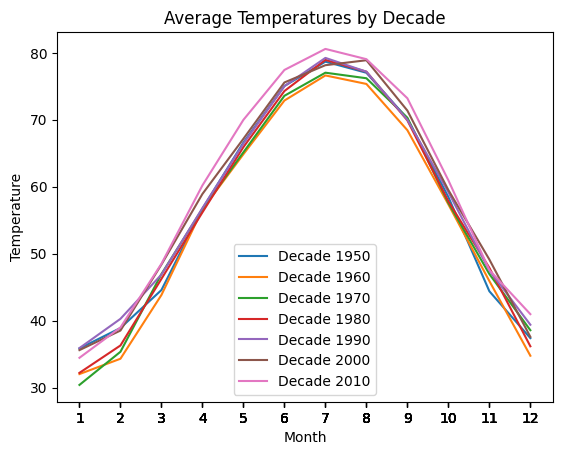

In [35]:
# Separate data by decades
decades = df_monthly_decade['Decade'].unique()

# Create a separate line for each decade
for decade in decades:
    subset = df_monthly_decade[df_monthly_decade['Decade'] == decade]
    plt.plot(subset['Month'], subset['Average_Temp'], label=f'Decade {decade}')

plt.legend()

# naming x axis
plt.xlabel('Month')

# naming y axis
plt.ylabel('Temperature')

# title to the graph
plt.title('Average Temperatures by Decade')

# x-axis labels 
plt.xticks(df_monthly_decade['Month'])

# Show the plot
plt.show()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27184 entries, 0 to 27183
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Station       27184 non-null  object        
 1   Date          27184 non-null  datetime64[ns]
 2   Average_Temp  27184 non-null  float64       
 3   Max_Temp      27179 non-null  float64       
 4   Min_Temp      27179 non-null  float64       
 5   Rain_Fall     27175 non-null  float64       
 6   Month         27184 non-null  int64         
 7   Day           27184 non-null  object        
 8   Year          27184 non-null  int64         
 9   Decade        27184 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 2.1+ MB


In [37]:
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt

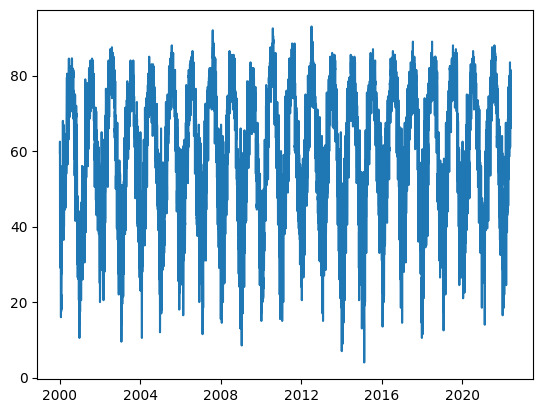

In [39]:
plt.plot(df ['Date'], df ['Average_Temp'])
plt.show()

The model only take 2 cols 

In [40]:
new_column = df[['Date', 'Average_Temp']] 
new_column.dropna(inplace=True)
new_column.columns = ['ds', 'y'] 
new_column.tail()

WARNING - (py.warnings._showwarnmsg) - /var/folders/t5/sxblnh9s6r744cwj7y86ts1r0000gn/T/ipykernel_10805/1246617776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_column.dropna(inplace=True)



,ds,y
27179,2022-05-31,80.0
27180,2022-06-01,81.5
27181,2022-06-02,73.0
27182,2022-06-03,72.0
27183,2022-06-04,72.0


This takes 49 mins to run on M1 MBA 

In [41]:
# n = NeuralProphet()
# model = n.fit(new_column, freq='D', epochs=5000)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
Finding best initial lr: 100%|██████████| 247/247 [00:00<00:00, 422.57it/s]


Epoch 5000: 100%|██████████| 5000/5000 [00:00<00:00, 8316.71it/s, loss=0.00356, v_num=2, MAE=6.440, RMSE=8.180, Loss=0.00411, RegLoss=0.000]   


predictions out to 2030. Combine to existing data and see how it graphs. do the 2000 and up.

In [77]:
future = n.make_future_dataframe(new_column, periods=3132)
forecast = n.predict(future)
forecast.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 293.41it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
3127,2030-12-27,None,36.335426,57.178463,-20.431173,-0.411866
3128,2030-12-28,None,36.089542,57.177753,-20.591812,-0.496398
3129,2030-12-29,None,36.322830,57.177036,-20.754671,-0.099535
3130,2030-12-30,None,36.360340,57.176327,-20.919651,0.103666
3131,2030-12-31,None,36.488823,57.175613,-21.086584,0.399791


saves the model to csv to pull from later so the model doesnt have to run every time you want to see it. 

In [78]:
forecast.to_csv('model.csv')

<Axes: xlabel='ds'>

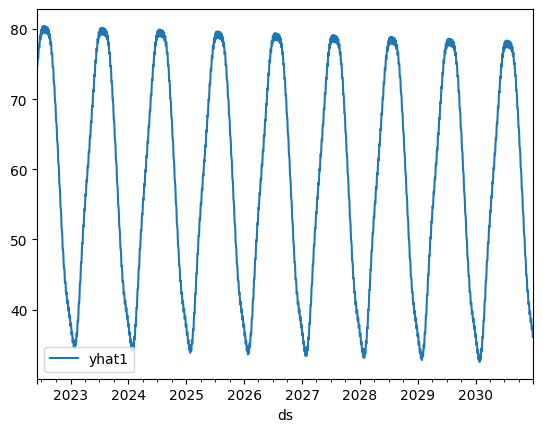

In [79]:
forecast.plot(x="ds", y="yhat1")

next step is to add this data to to my current data set to see what the model say the future looks like. 